In [196]:
# Esther Max-Onakpoya on January 17th 2019
# Script for math model stuff

import math
import numpy as np
from scipy.stats import truncnorm
from scipy import stats
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from matplotlib.markers import TICKDOWN


In [197]:
'''
Constants
'''
### Physical Network
ftToMile = 1 / 5280
sqftToSqmi = ftToMile * ftToMile
countyArea = 278  # 278 Sqmiles
cityArea = 2.409  # size in sq miles
totalPatientsInCounty = 19  # 19 patients
totalPeopleInCounty = 12228
OwingsvillePopulation_2 = 1488
min_patient_number = 2
max_patient_number = .6 * 1488
estimatedPatientsInSampleCity = round(
    19 * OwingsvillePopulation_2 / totalPeopleInCounty)  # lower limit of data carriers
OwingsvillePopulation = math.floor(.269 * OwingsvillePopulation_2)
# higher limit of data carriers https://datausa.io/profile/geo/owingsville-ky/#category_age
bluetoothRange = 800 * ftToMile  # 800feet working in miles though
bluetoothArea = math.pi * (bluetoothRange ** 2)
meterInFt = 3.28084
lowerTransmissionFactor = 0.25
upperTransmissionFactor = 0.75  # conservative major quartile
roomUnitSize = 100 * sqftToSqmi  # size of each cell in grid ~ 10ft*10ft
gridLength = math.ceil(math.sqrt(cityArea / roomUnitSize))
grid = np.zeros(shape=(gridLength, gridLength))  # 820*820
walking_speed = 265.092 * ftToMile  # per min https://core.ac.uk/download/pdf/82652123.pdf
walking_speed_grid = 26.5  # grid per min https://core.ac.uk/download/pdf/82652123.pdf
densely_covered_region = 0.66
cancer_patient_estimate = round(82*(1488/12228))
radius_mean = 60
radius_std = 20
radius_lower = 20
radius_upper = 80

### Cost
battery_life_average = 22.6  # hours https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7983341
battery_life_std = 10
storage_minimum = 1000  # in megabit
message_size = 8 # 0.00112  # in megabit
energy_consumption_rate_min = 0.15  # in J/ megabit
energy_consumption_rate_max = 1.13  # in J/ megabit
energy_consumption_rate_max_dtn = (energy_consumption_rate_min+energy_consumption_rate_max)/2  # in J/ megabit
# cost_incurred_device = 0.002 # $/ megabit
cost_incurred_connectivity = 0.002 # $/ megabit
cost_participant_acquisition = 0 # flat fee
battery_life_min = 0
battery_life_max = 70
speed_incentive_constant = 10 # r
speed_incentive_fraction = 0.2 # F
satellite_cost_per_day = 50/30 # https://www.exede.com/plan-results/liberty12-unlimited/


# Probabilities
number_of_ind_reps = 50
seed_start = 150
seed_array = list(range(0, 100))
start_time_array = [6.5, 9.5, 16.5, 19]
duration = 24
significance_level = 0.05

In [198]:
class CellConnectivity(Enum):
    NONE = 0
    BLUETOOTH = 1
    INTERNET_ROUTER = 2
    INTERNET_CELL = 3
    # https://www.lifewire.com/range-of-typical-wifi-network-816564


class NodeType(Enum):
    PATIENT = 1
    CAREGIVER = 2
    INTERMEDIARY = 3
    CLINICAL_STAFF = 4
    DESTINATION = 5

class AnalysisType(Enum):
    DTN = 0
    HYBRID = 1
    INTERNET = 2

class FilePresent(Enum):
    YES = 1
    NO = 0


class Location:
    def __init__(self, xcord, ycord):
        self.xcord = xcord
        self.ycord = ycord


class Node:
    def __init__(self, id, home, location, connectivity, node_type, file_present, employment_location):
        self.id = id
        self.home = home
        self.location = location
        self.connectivity = connectivity
        self.node_type = node_type
        self.file_present = file_present
        self.employment_location = employment_location


class Cost:
    def __init__(self, dtn, hybrid, internet):
        self.dtn = dtn
        self.hybrid = hybrid
        self.internet = internet


class transmission_cost_params:
    def __init__(self, node_battery_life, node_energy_dtn, node_energy, node_data, node_memory):
        self.node_battery_life = node_battery_life
        self.node_energy_dtn = node_energy_dtn
        self.node_energy = node_energy
        self.node_data = node_data
        self.node_memory = node_memory


class DeliveryTime:
    def __init__(self, dtn_mean, hybrid_mean, internet_mean, dtn_median, hybrid_median, internet_median):
        self.dtn_mean = dtn_mean
        self.hybrid_mean = hybrid_mean
        self.internet_mean = internet_mean
        self.dtn_median = dtn_median
        self.hybrid_median = hybrid_median
        self.internet_median = internet_median


class DeliveryProbability:
    def __init__(self, dtn, hybrid, internet):
        self.dtn = dtn
        self.hybrid = hybrid
        self.internet = internet


class GraphObject:
    def __init__(self, dtn, hybrid, internet, markings):
        self.dtn = dtn
        self.hybrid = hybrid
        self.internet = internet
        self.markings = markings


class LabelObject:
    def __init__(self, x_label, y_label, title, x_ticks_tuple):
        self.x_label = x_label
        self.y_label = y_label
        self.title = title
        self.x_ticks_tuple = x_ticks_tuple


class VariedParameter(Enum):
    patients = 'Number of Patients'
    ratio = 'Ratio of Population Participating in Network'

    
class CostGraphParams:
    def __init__(self, local_cost, local_cost_err, local_cost_label, additional_data_dict):
        self.local_cost = local_cost
        self.local_cost_err = local_cost_err
        self.local_cost_label = local_cost_label
        self.additional_data_dict = additional_data_dict

        
class GraphParams:
    def __init__(self, local, local_err, local_label):
        self.local = local
        self.local_err = local_err
        self.local_label = local_label

        

In [199]:

def isWithinCircle(source_loc, source_radius, relay_loc, relay_radius):
    result = 0
    distance = math.sqrt(((source_loc.xcord - relay_loc.xcord) ** 2) + ((source_loc.ycord - relay_loc.ycord) ** 2))
    if min(source_radius, relay_radius) >= distance:
        result = 1
    return result


# Generating Intermediary Nodes
employment_location_xcord_seed = []
employment_location_ycord_seed = []
def generateIntermediaryNodes(ratio, srcs_number):
    counter = 1
    if_counter = 0
    node_name_array = []
    intermediary_node_array = []
    initial_location = np.random.randint(0, gridLength, round(ratio * (math.sqrt(OwingsvillePopulation - srcs_number))))
    initial_location.sort()
    employment_location_xcord_seed.extend(np.random.randint(0, gridLength, 30))
    employment_location_ycord_seed.extend(np.random.randint(0, gridLength, 30))
    for node_initial_loc_x in initial_location:
        for node_initial_loc_y in initial_location:
            node_name = "intermediary_node" + str(counter)
            node_name_array = [node_name_array, node_name]
            current_node_initial_loc = Location(node_initial_loc_x, node_initial_loc_y)
            current_nodetype = NodeType.INTERMEDIARY
            current_node_connectivity = CellConnectivity.BLUETOOTH
            current_node_employment_loc = Location(-1, -1)
            destination_location = Location(round(gridLength / 2), round(gridLength / 2))
            med_counter = 0
            rand_value = np.random.random()
            if counter % 5 == 0:
                current_node_connectivity = CellConnectivity.INTERNET_CELL
            if counter % 15 != 0:
                # https://fred.stlouisfed.org/series/KYBATH1URN ~6.5% unemployment rate
                current_node_employment_loc = Location(employment_location_xcord_seed[if_counter],
                                                       employment_location_ycord_seed[if_counter])
                if_counter += 1
                if if_counter == 26:
                    if_counter = 0
               
            if med_counter < 2 and rand_value > 0.7:
                # https://www.govinfo.gov/content/pkg/CFR-2017-title42-vol5/xml/CFR-2017-title42-vol5-sec491-8.xml ~rural clinics must have at least 2 people
                current_nodetype = NodeType.CLINICAL_STAFF
                current_node_employment_loc = destination_location
                med_counter += 1

            files_contained = []
            files_contained_index = 0
            while files_contained_index < srcs_number:
                files_contained.append(FilePresent.NO)
                files_contained_index += 1

            currently_generated_node = Node(node_name, current_node_initial_loc, current_node_initial_loc,
                                            current_node_connectivity, current_nodetype,
                                            files_contained, current_node_employment_loc)
            # http://www.pewinternet.org/fact-sheet/internet-broadband/ ~1 in 5 rural americans have cell as their
            # primary internet connectivity
            counter += 1
            intermediary_node_array.append(currently_generated_node)

    return intermediary_node_array

def generate_patients(number_of_patients):
    counter = 1
    if_counter = 0
    if_counter_caregiver = 6
    node_name_array = []
    patient_array = []
    caregiver_array = []
    # https://www.cdc.gov/chronicdisease/index.htm

    initial_location = np.random.randint(0, gridLength, math.floor(math.sqrt(number_of_patients)))
    initial_location.sort()

    for node_initial_loc_x in initial_location:
        for node_initial_loc_y in initial_location:
            node_name = "patient" + str(counter)
            node_name_caregiver = "caregiver" + str(counter)
            # node_name_array = node_name_array.append(node_name)
            current_node_initial_loc = Location(node_initial_loc_x, node_initial_loc_y)
            current_nodetype = NodeType.PATIENT
            caregiver_current_nodetype = NodeType.CAREGIVER
            current_node_connectivity = CellConnectivity.BLUETOOTH
            current_node_employment_loc = Location(-1, -1)
            current_node_employment_loc_caregiver = current_node_employment_loc
            med_counter = 0
            rand_value = np.random.random()
            if counter % 10 == 0:  # 20 percent caregiver + patient
                current_node_connectivity = CellConnectivity.INTERNET_CELL
            if counter % 15 != 0 and counter > 2:  # first 2 patients are unemployed in the begining mdel
                # https://fred.stlouisfed.org/series/KYBATH1URN ~6.5% unemployment rate
                current_node_employment_loc = Location(employment_location_xcord_seed[if_counter],
                                                       employment_location_ycord_seed[if_counter])
                current_node_employment_loc_caregiver = Location(employment_location_xcord_seed[if_counter_caregiver],
                                                                 employment_location_ycord_seed[if_counter_caregiver])
                if_counter += 1
                if if_counter == 26:  # 26 POIs
                    if_counter = 0
                if_counter_caregiver += 1
                if if_counter_caregiver == 26:  # 26 POIs
                    if_counter_caregiver = 0
                # print("currently generated node: ", current_node_employment_loc.ycord, current_node_employment_loc.xcord)

            files_contained = []
            files_contained_index = 0
            while files_contained_index < number_of_patients:
                if files_contained_index == counter-1:
                    files_contained.append(FilePresent.YES)
                else:
                    files_contained.append(FilePresent.NO)
                files_contained_index += 1

            currently_generated_node = Node(node_name, current_node_initial_loc, current_node_initial_loc,
                                            current_node_connectivity, current_nodetype,
                                            files_contained, current_node_employment_loc)
            currently_generated_node_caregiver = Node(node_name_caregiver, current_node_initial_loc,
                                                      current_node_initial_loc,
                                                      current_node_connectivity, caregiver_current_nodetype,
                                                      files_contained, current_node_employment_loc_caregiver)
            # http://www.pewinternet.org/fact-sheet/internet-broadband/ ~1 in 5 rural americans have cell as their
            # primary internet connectivity
            counter += 1
            patient_array.append(currently_generated_node)
            caregiver_array.append(currently_generated_node_caregiver)

    while counter < number_of_patients + 1:
        extra_xcord = np.random.randint(1, 820)
        extra_ycord = np.random.randint(1, 820)
        current_node_initial_loc = Location(extra_xcord, extra_ycord)
        employment_loc = Location(-1, -1)
        node_name = "Patient" + str(counter)
        node_name_caregiver = "caregiver" + str(counter)
        current_node_connectivity = CellConnectivity.BLUETOOTH
        if counter % 10 == 0:  # 20 percent caregiver + patient
            current_node_connectivity = CellConnectivity.INTERNET_CELL

        files_contained = []
        files_contained_index = 0
        while files_contained_index < number_of_patients:
            if files_contained_index == counter:
                files_contained.append(FilePresent.YES)
            else:
                files_contained.append(FilePresent.NO)
            files_contained_index += 1

        currently_generated_node = Node(node_name, current_node_initial_loc, current_node_initial_loc,
                                        current_node_connectivity, NodeType.PATIENT,
                                        files_contained, employment_loc)
        currently_generated_node_caregiver = Node(node_name_caregiver, current_node_initial_loc,
                                                  current_node_initial_loc,
                                                  current_node_connectivity, NodeType.CAREGIVER,
                                                  files_contained, employment_loc)
        # http://www.pewinternet.org/fact-sheet/internet-broadband/ ~1 in 5 rural americans have cell as their
        # primary internet connectivity

        counter += 1
        patient_array.append(currently_generated_node)
        caregiver_array.append(currently_generated_node_caregiver)

    if number_of_patients == 2:
        patient_array = []
        caregiver_array = []
        employment_loc = Location(-1, -1)
        patient1_location = Location(0, gridLength)
        patient2_location = Location(gridLength, gridLength)
        patient1 = Node("patient1", patient1_location, patient1_location, CellConnectivity.BLUETOOTH, NodeType.PATIENT,
                        [FilePresent.YES, FilePresent.NO], employment_loc)
        patient2 = Node("patient2", patient2_location, patient2_location, CellConnectivity.BLUETOOTH, NodeType.PATIENT,
                        [FilePresent.NO, FilePresent.YES], employment_loc)
        caregiver1 = Node("caregiver1", patient1_location, patient1.location, CellConnectivity.BLUETOOTH,
                          NodeType.CAREGIVER,
                          [FilePresent.YES, FilePresent.NO], employment_loc)
        caregiver2 = Node("caregiver2", patient2.location, patient2.location, CellConnectivity.BLUETOOTH,
                          NodeType.CAREGIVER,
                          [FilePresent.NO, FilePresent.YES], employment_loc)
        patient_array.append(patient1)
        patient_array.append(patient2)
        caregiver_array.append(caregiver1)
        caregiver_array.append(caregiver2)
    return caregiver_array, patient_array


"""
Settings
"""

def trunc_normal_dist(mean, sd, low, upp, n=1):
    x = truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return x.rvs(n)


def try_int(x):
    try:
        return int(x)
    except ValueError:
        return None


def file_present_array(patient_array, caregiver_array):
    file_present = []
    index = 0
    while index < len(patient_array):
        file_present_temp = []
        file_present_temp.extend((patient_array[index], caregiver_array[index]))
        file_present.append(file_present_temp)
        index += 1
    return file_present


def file_absent_array(intermediary_node_array, number_of_patients):
    file_absent = []
    index = 0
    while index < number_of_patients:
        file_absent_temp = []
        file_absent_temp.extend(intermediary_node_array)
        file_absent.append(file_absent_temp)
        index += 1
    return file_absent


def traveling_function(speed, time, destination_point, src_point):
    distance_covered = speed * time
    current_location = destination_point
    
    del_x = destination_point.xcord - src_point.xcord
    del_y = destination_point.ycord - src_point.ycord
    distance_src_dest = math.sqrt((del_x ** 2) + (del_y ** 2))
    
    if distance_src_dest > 0:
        new_xcord = math.floor((distance_covered * del_x / distance_src_dest) + src_point.xcord)
        new_ycord = math.floor((distance_covered * del_y / distance_src_dest) + src_point.ycord)
        current_location = Location(new_xcord, new_ycord)
    return current_location


def changeLocation(node, period, current_time):
    # http://oatao.univ-toulouse.fr/4526/1/Nguyen_4526.pdf
    
    employment_location_xcord_seed = np.random.randint(0, gridLength, 30)
    employment_location_ycord_seed = np.random.randint(0, gridLength, 30)
    state_var = np.random.random()
    random_poi = np.random.randint(0, 24)
    if period == 1:
        # 19-6 Using probablities at 19 hours
        period_start_time = 19
        if current_time == period_start_time: #Initial Probabilities
            home_probability_fulltime = 0.704697987
            work_probability_fulltime = 0.079418345
            poi_probability_fulltime = 0.215883669
            home_probability_unemp = 0.850498339
            work_probability_unemp = 0
            poi_probability_unemp = 0.149501661
            if node.node_type == NodeType.PATIENT or node.node_type == NodeType.CAREGIVER or \
                    node.employment_location.xcord < 0:
                if state_var > home_probability_unemp:
                    node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                else:
                    node.location = node.home
            else:
                if state_var < home_probability_fulltime:
                    node.location = node.home
                elif state_var < (home_probability_fulltime+work_probability_fulltime):
                    node.location = node.employment_location
                else:
                    node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
        else: #Transition matrix
            home_to_home_unemp = 0.94
            home_to_poi_unemp = 0.064
            poi_to_home_unemp = 0.37
            poi_to_poi_unemp = 0.63
            ##
            home_to_home_emp = 0.85416667
            home_to_work_emp = 0.01875
            home_to_poi_emp = 0.12708333
            work_to_home_emp = 0.14285714
            work_to_work_emp = 0.81428571
            poi_to_home_emp = 0.38961039
            poi_to_poi_emp = 0.57792208
            if node.node_type == NodeType.PATIENT or node.node_type == NodeType.CAREGIVER or \
                    node.employment_location.xcord < 0: # check where unemployed nodes be
                if node.location == node.home: # check if unemployed nodes should remain where they are or move
                    if state_var > home_to_home_unemp:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                    else:
                        node.location = node.home
                else:
                    if state_var > poi_to_home_unemp:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                    else:
                        node.location = node.home
            else:  # check where employed nodes be
                if node.location == node.home: # check if unemployed nodes should remain where they are or move
                    if state_var < home_to_home_emp:
                        node.location = node.home
                    elif state_var < (home_to_home_emp + home_to_work_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
                elif node.location == node.employment_location:
                    if state_var < work_to_home_emp:
                        node.location = node.home
                    elif state_var < (work_to_home_emp + work_to_work_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
                else:
                    if state_var < poi_to_home_emp:
                        node.location = node.home
                    elif state_var < (poi_to_home_emp + poi_to_poi_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
    if period == 2:
        # 19-6 Using probablities at 19 hours

        period_start_time = 6.5
        if current_time == period_start_time: #Initial Probabilities
            home_probability_fulltime = 0.708759954
            work_probability_fulltime = 0.160409556
            poi_probability_fulltime = 0.130830489
            home_probability_unemp = 0.930394432
            poi_probability_unemp = 0.069605568
            if node.node_type == NodeType.PATIENT or node.node_type == NodeType.CAREGIVER or \
                    node.employment_location.xcord < 0:
                if state_var > home_probability_unemp:
                    node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                else:
                    node.location = node.home
            else:
                if state_var < home_probability_fulltime:
                    node.location = node.home
                elif state_var < (home_probability_fulltime+work_probability_fulltime):
                    node.location = node.employment_location
                else:
                    node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
        else: #Transition matrix
            home_to_home_unemp = 0.97
            poi_to_home_unemp = 0.59
            ##
            home_to_home_emp = 0.85968379
            home_to_work_emp = 0.07905138
            work_to_home_emp = 0.17037037
            work_to_work_emp = 0.61481481
            poi_to_home_emp = 0.5060241
            poi_to_poi_emp = 0.31325301
            if node.node_type == NodeType.PATIENT or node.node_type == NodeType.CAREGIVER or \
                    node.employment_location.xcord < 0: # check where unemployed nodes be
                if node.location == node.home: # check if unemployed nodes should remain where they are or move
                    if state_var > home_to_home_unemp:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                    else:
                        node.location = node.home
                else:
                    if state_var > poi_to_home_unemp:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                    else:
                        node.location = node.home
            else:  # check where employed nodes be
                if node.location == node.home: # check if unemployed nodes should remain where they are or move
                    if state_var < home_to_home_emp:
                        node.location = node.home
                    elif state_var < (home_to_home_emp + home_to_work_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
                elif node.location == node.employment_location:
                    if state_var < work_to_home_emp:
                        node.location = node.home
                    elif state_var < (work_to_home_emp + work_to_work_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
                else:
                    if state_var < poi_to_home_emp:
                        node.location = node.home
                    elif state_var < (poi_to_home_emp + poi_to_poi_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
    if period == 3:
        # 19-6 Using probablities at 19 hours
        period_start_time = 9.5
        if current_time == period_start_time: #Initial Probabilities
            home_probability_fulltime = 0.436090226
            work_probability_fulltime = 0.34962406
            home_probability_unemp = 0.762954796
            if node.node_type == NodeType.PATIENT or node.node_type == NodeType.CAREGIVER or \
                    node.employment_location.xcord < 0:
                if state_var > home_probability_unemp:
                    node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                else:
                    node.location = node.home
            else:
                if state_var < home_probability_fulltime:
                    node.location = node.home
                elif state_var < (home_probability_fulltime+work_probability_fulltime):
                    node.location = node.employment_location
                else:
                    node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
        else: #Transition matrix
            home_to_home_unemp = 0.89
            poi_to_home_unemp = 0.36
            ##
            home_to_home_emp = 0.80066445
            home_to_work_emp = 0.08305648
            work_to_home_emp = 0.06296296
            work_to_work_emp = 0.9
            poi_to_home_emp = 0.30081301
            poi_to_poi_emp = 0.64227642
            if node.node_type == NodeType.PATIENT or node.node_type == NodeType.CAREGIVER or \
                    node.employment_location.xcord < 0: # check where unemployed nodes be
                if node.location == node.home: # check if unemployed nodes should remain where they are or move
                    if state_var > home_to_home_unemp:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                    else:
                        node.location = node.home
                else:
                    if state_var > poi_to_home_unemp:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                    else:
                        node.location = node.home
            else:  # check where employed nodes be
                if node.location == node.home: # check if unemployed nodes should remain where they are or move
                    if state_var < home_to_home_emp:
                        node.location = node.home
                    elif state_var < (home_to_home_emp + home_to_work_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
                elif node.location == node.employment_location:
                    if state_var < work_to_home_emp:
                        node.location = node.home
                    elif state_var < (work_to_home_emp + work_to_work_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
                else:
                    if state_var < poi_to_home_emp:
                        node.location = node.home
                    elif state_var < (poi_to_home_emp + poi_to_poi_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
    if period == 4:
        # 19-6 Using probablities at 19 hours
        period_start_time = 16.5
        if current_time == period_start_time: #Initial Probabilities
            home_probability_fulltime = 0.479713604
            work_probability_fulltime = 0.19928401
            home_probability_unemp = 0.770345596
            if node.node_type == NodeType.PATIENT or node.node_type == NodeType.CAREGIVER or \
                    node.employment_location.xcord < 0:
                if state_var > home_probability_unemp:
                    node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                else:
                    node.location = node.home
            else:
                if state_var < home_probability_fulltime:
                    node.location = node.home
                elif state_var < (home_probability_fulltime+work_probability_fulltime):
                    node.location = node.employment_location
                else:
                    node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
        else: #Transition matrix
            home_to_home_unemp = 0.91
            poi_to_home_unemp = 0.30
            ##
            home_to_home_emp = 0.80118694
            home_to_work_emp = 0.02670623
            work_to_home_emp = 0.04216867
            work_to_work_emp = 0.87951807
            poi_to_home_emp = 0.2815534
            poi_to_poi_emp = 0.66019417
            if node.node_type == NodeType.PATIENT or node.node_type == NodeType.CAREGIVER or \
                    node.employment_location.xcord < 0: # check where unemployed nodes be
                if node.location == node.home: # check if unemployed nodes should remain where they are or move
                    if state_var > home_to_home_unemp:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                    else:
                        node.location = node.home
                else:
                    if state_var > poi_to_home_unemp:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                             employment_location_ycord_seed[random_poi])
                    else:
                        node.location = node.home
            else:  # check where employed nodes be
                if node.location == node.home: # check if unemployed nodes should remain where they are or move
                    if state_var < home_to_home_emp:
                        node.location = node.home
                    elif state_var < (home_to_home_emp + home_to_work_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
                elif node.location == node.employment_location:
                    if state_var < work_to_home_emp:
                        node.location = node.home
                    elif state_var < (work_to_home_emp + work_to_work_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])
                else:
                    if state_var < poi_to_home_emp:
                        node.location = node.home
                    elif state_var < (poi_to_home_emp + poi_to_poi_emp):
                        node.location = node.employment_location
                    else:
                        node.location = Location(employment_location_xcord_seed[random_poi],
                                                 employment_location_ycord_seed[random_poi])


def period_finder(current_time):
    while current_time > 24:
        current_time = current_time - 24
    if current_time < 6.5:
        period = 1
    elif current_time < 9.5:
        period = 2
    elif current_time < 16.5:
        period = 3
    elif current_time < 19:
        period = 4
    else:
        period = 1
    return period


def generate_destination(number_of_patients):
    index = 0
    destination_location = Location(round(gridLength / 2), round(gridLength / 2))
    dtn_destination_file_status = []
    hybrid_destination_file_status = []
    internet_file_status = []
    employment_loc = Location(-1, -1)
    while index < number_of_patients:
        dtn_destination_file_status.append(FilePresent.NO)
        hybrid_destination_file_status.append(FilePresent.NO)
        internet_file_status.append(FilePresent.NO)
        index += 1
    destination = Node("destination", destination_location, destination_location, CellConnectivity.INTERNET_ROUTER,
                       NodeType.DESTINATION,
                       [dtn_destination_file_status, hybrid_destination_file_status, internet_file_status], employment_loc)# for DTN and hybrid
    return destination


def move(current_time, node, node_id_loc_dict):
    # check if node.id is in the list
    if node.id in node_id_loc_dict:
        node.location = node_id_loc_dict[node.id]

    else:
        period = period_finder(current_time)
        changeLocation(node, period, current_time)
        node_id_loc_dict[node.id] = node.location


def calculateCost(analysisType, node, transmission_cost_params_dict, cost_incurred_device):
    initial_participation = False
    
    if node.id not in transmission_cost_params_dict:
        node_battery_life = trunc_normal_dist(battery_life_average, battery_life_std, battery_life_min,
                                          battery_life_max, n=1)
        node_energy_dtn = trunc_normal_dist((energy_consumption_rate_min + energy_consumption_rate_max_dtn) / 2,
                                            (energy_consumption_rate_min + energy_consumption_rate_max_dtn) / 4,
                                            energy_consumption_rate_min, energy_consumption_rate_max_dtn, n=1)
        node_energy = trunc_normal_dist((energy_consumption_rate_min + energy_consumption_rate_max) / 2,
                                            (energy_consumption_rate_min + energy_consumption_rate_max) / 4,
                                            energy_consumption_rate_min, energy_consumption_rate_max, n=1)
        node_data = 1
        node_memory = storage_minimum
        transmission_cost_params_dict[node.id] = transmission_cost_params(node_battery_life, node_energy_dtn,
                                                                          node_energy, node_data, node_memory)
        initial_participation = True
        
    if initial_participation:
        transmission_cost = cost_participant_acquisition
    else:
        transmission_cost = 0
        
    if analysisType == AnalysisType.DTN:
        upsilon = (transmission_cost_params_dict[node.id].node_battery_life/battery_life_max) + \
                  (transmission_cost_params_dict[node.id].node_energy_dtn/energy_consumption_rate_max_dtn) + \
                  (message_size/transmission_cost_params_dict[node.id].node_memory)
        transmission_cost = transmission_cost + (cost_incurred_device/upsilon)
    elif analysisType == AnalysisType.HYBRID:
        upsilon = (transmission_cost_params_dict[node.id].node_battery_life / battery_life_max) + \
                  (transmission_cost_params_dict[node.id].node_energy / energy_consumption_rate_max) + \
                  (message_size / transmission_cost_params_dict[node.id].node_memory)
        transmission_cost =  transmission_cost + (cost_incurred_device/upsilon)+\
                            (cost_incurred_connectivity / transmission_cost_params_dict[node.id].node_data)
    elif analysisType == AnalysisType.INTERNET:
        upsilon = (transmission_cost_params_dict[node.id].node_battery_life / battery_life_max) + \
                  (transmission_cost_params_dict[node.id].node_energy / energy_consumption_rate_max) + \
                  (message_size / transmission_cost_params_dict[node.id].node_memory)
        transmission_cost =  transmission_cost + (cost_incurred_device/upsilon)+\
                            (cost_incurred_connectivity / transmission_cost_params_dict[node.id].node_data)
    else:
        raise Exception("Calculate Cost does not enter analysis type")

    return transmission_cost, upsilon


def calculateSpeedIncentive(time, start_time, duration, upsilon):
    val = upsilon[0].item()
    a = (cost_incurred_connectivity / val)
    b = ((time - start_time) * math.log(speed_incentive_constant * cost_incurred_connectivity))
    c = (1 - duration)
    d = math.exp(b/c)
    e = speed_incentive_fraction + d
    speed_incentive = e * a
    if speed_incentive < 0:
        print(speed_incentive)

    return speed_incentive


def i_cant_shout_sum(list):
    list_index = 0
    list_sum = 0
    while list_index < len(list):
        list_sum = list_sum + list[list_index]
        list_index += 1
    return list_sum


def problemOne(number_of_patients, ratio, start_time, duration):
    patient_array, caregiver_array = generate_patients(number_of_patients)
    intermediary_node_array = generateIntermediaryNodes(ratio, number_of_patients)
    file_present = file_present_array(patient_array, caregiver_array)
    file_absent = file_absent_array(intermediary_node_array, number_of_patients)
    destination = generate_destination(number_of_patients)

    t_0 = start_time
    t_step = 0.5
    t_f = duration + t_0
    radius = trunc_normal_dist(radius_mean, radius_std, radius_lower, radius_upper, n=1)[0]
    radius_2 = trunc_normal_dist(radius_mean, radius_std, radius_lower, radius_upper, n=1)[0]  

    cost_incurred_device = cost_incurred_connectivity/(ratio*OwingsvillePopulation)

    current_time = t_0
    node_id_loc_dict = {}
    transmission_cost_params_dict = {} # key: node_id value: [energy, battery, memory, data]
    delivery_rate = 0
    hybrid_delivery_rate = 0
    hybrid_counter = 0
    time_delivered = 0
    time_delivered_array = []
    hybrid_time_delivered_array = []
    hybrid_time_delivered = 0
    transmitted_messages = 0
    transmitted_messages_array = [0] * number_of_patients
    hybrid_transmitted_messages = 0
    delivery_probabilities = []
    hybrid_delivery_probabilities = []
    files_in_destination = 0
    files_in_destination_hybrid = 0
    files_in_destination_internet = 0
    hybrid_index_list = []
    time_index = 0
    internet_time_delivered_array = []
    internet_index_list = []
    internet_delivery_probabilities = []
    delivery_time = DeliveryTime(0, 0, 0, 0, 0, 0)
    cost = Cost(0, 0, 0)
    delivery_probability = DeliveryProbability(0, 0, 0)

    dtn_cost = [0] * number_of_patients
    hybrid_cost = [0] * number_of_patients # internet set up cost for destination
    internet_cost = satellite_cost_per_day # internet set up cost for destination

    if current_time == t_0:
        index = 0
        period_1 = period_finder(current_time)
        while index < number_of_patients:
            for node_i in file_present[index]:
                changeLocation(node_i, period_1, current_time)
            for node_j in file_absent[index]:
                changeLocation(node_j, period_1, current_time)
            index += 1

    while current_time < t_f:  # changes time step to get to destination
        p1_index = 0
        while p1_index < number_of_patients:  # transmits each patients information; change node location after this

            if destination.file_present[0][
                p1_index] == FilePresent.NO:  # checks if the current patients file is not at destination

                for node_i in file_present[p1_index]:
                    for node_j in file_absent[p1_index]:
                        if isWithinCircle(node_i.location, radius, node_j.location, radius_2) != 0:
                            node_j.file_present[p1_index] = FilePresent.YES
                            transmitted_messages += 1
                            transmitted_messages_array[p1_index] = transmitted_messages_array[p1_index] + 1

                            # Cost analysis

                            #### DTN ####
                            if node_i.node_type != NodeType.PATIENT:
                                trans_cost_dtn, upsilon_dtn = calculateCost(AnalysisType.DTN, node_i,
                                                                    transmission_cost_params_dict, cost_incurred_device)
                                dtn_cost[p1_index] = dtn_cost[p1_index]+trans_cost_dtn

                            #### Hybrid ####
                            if node_j.connectivity == CellConnectivity.INTERNET_CELL:
                                if destination.file_present[1][p1_index] == FilePresent.NO:
                                    destination.file_present[1][p1_index] = FilePresent.YES 
                                    hybrid_counter += 1
                                    hybrid_time_delivered = current_time - t_0
                                    hybrid_time_delivered_array.append(hybrid_time_delivered)
                                    hybrid_transmitted_messages = hybrid_transmitted_messages + transmitted_messages_array[p1_index]
                                    hybrid_index_list.append(p1_index)
                                    trans_cost_hy, upsilon_hy = calculateCost(AnalysisType.HYBRID, node_j,
                                                                    transmission_cost_params_dict, cost_incurred_device)
                                    hybrid_cost[p1_index] = trans_cost_hy + dtn_cost[p1_index]+\
                                                            calculateSpeedIncentive(current_time, start_time,
                                                                                    duration, upsilon_hy)# added speed incentive cost here

                            #### Internet ####
                            if node_j.connectivity == CellConnectivity.INTERNET_CELL and \
                                    node_i.node_type == NodeType.PATIENT:
                                if destination.file_present[2][p1_index] == FilePresent.NO:
                                    destination.file_present[2][p1_index] = FilePresent.YES
                                    internet_time_delivered = current_time - t_0
                                    internet_time_delivered_array.append(internet_time_delivered)
                                    internet_index_list.append(p1_index)
                                    trans_cost_int, upsilon_int = calculateCost(AnalysisType.INTERNET, node_j,
                                                                    transmission_cost_params_dict, cost_incurred_device)
                                    internet_cost = internet_cost+trans_cost_int + calculateSpeedIncentive(current_time,
                                                                                                           start_time,
                                                                                                           duration,
                                                                                                           upsilon_int) # added speed incentive cost here
                            # switching lists
                            file_present[p1_index].append(node_j)
                            file_absent[p1_index].remove(node_j)

                        move(current_time, node_j, node_id_loc_dict)

                    if isWithinCircle(destination.location, radius, node_i.location, radius_2) != 0:
                        trans_cost_dtn, upsilon_dtn = calculateCost(AnalysisType.DTN, node_i,
                                                                    transmission_cost_params_dict,
                                                                    cost_incurred_device)

                        if destination.file_present[1][p1_index] == FilePresent.NO:
                            hybrid_time_delivered = current_time - t_0 # change to minue
                            hybrid_time_delivered_array.append(hybrid_time_delivered)
                            destination.file_present[1][p1_index] = FilePresent.YES
                            hybrid_cost[p1_index] = dtn_cost[p1_index]
                            hybrid_cost[p1_index] = hybrid_cost[p1_index]+ calculateSpeedIncentive(current_time, start_time, duration, upsilon_dtn)# add speed incentive cost here

                        destination.file_present[0][p1_index] = FilePresent.YES
                        time_delivered = current_time - t_0  # change to minue
                        time_delivered_array.append(time_delivered)
                        transmitted_messages += 1
                        dtn_cost[p1_index] = dtn_cost[p1_index] + calculateSpeedIncentive(current_time, start_time, duration, upsilon_dtn) # add speed incentive cost here

                        if destination.file_present[2][p1_index] == FilePresent.NO and node_i.node_type == NodeType.PATIENT:
                            internet_time_delivered = current_time - t_0 # change to minue
                            internet_time_delivered_array.append(internet_time_delivered)
                            destination.file_present[2][p1_index] = FilePresent.YES

                    move(current_time, node_i, node_id_loc_dict)

            files_in_destination = 0
            destination_file_index = 0
            for files in destination.file_present[0]:  # checks if all files are present in destination to return current time
                if destination.file_present[0][destination_file_index] == FilePresent.YES:
                    files_in_destination += 1
                destination_file_index += 1

            files_in_destination_hybrid = 0
            destination_file_index = 0
            for files in destination.file_present[1]:  # checks if all files are present in destination to return current time
                if destination.file_present[1][destination_file_index] == FilePresent.YES:
                    files_in_destination_hybrid += 1
                destination_file_index += 1

            files_in_destination_internet = 0
            destination_file_index = 0
            for files in destination.file_present[2]:  # checks if all files are present in destination to return current time
                if destination.file_present[2][destination_file_index] == FilePresent.YES:
                    files_in_destination_internet += 1
                destination_file_index += 1

            hybrid_time_delivered_median = np.median(hybrid_time_delivered_array)
            time_delivered_median = np.median(time_delivered_array)
            internet_time_delivered_median = np.median(internet_time_delivered_array)
            
            if len(hybrid_time_delivered_array) < 1:
                hybrid_time_delivered_mean = 0
            else:
                hybrid_time_delivered_mean = max(hybrid_time_delivered_array)# np.mean(hybrid_time_delivered_array)
            if len(time_delivered_array) < 1:
                time_delivered_mean = 0
            else:
                time_delivered_mean = max(time_delivered_array)# np.mean(time_delivered_array)
            if len(internet_time_delivered_array) < 1:
                internet_time_delivered_mean = 0
            else:
                internet_time_delivered_mean = max(internet_time_delivered_array)# np.mean(internet_time_delivered_array)
                
            delivery_time = DeliveryTime(time_delivered_mean, hybrid_time_delivered_mean,
                                        internet_time_delivered_mean, time_delivered_median, hybrid_time_delivered_median,
                                         internet_time_delivered_median)
            hybrid_cost_sum = sum(hybrid_cost)
            if type(hybrid_cost_sum) is np.ndarray:
                hybrid_cost_sum = hybrid_cost_sum.item() + satellite_cost_per_day
            else:
                hybrid_cost_sum = hybrid_cost_sum + satellite_cost_per_day

            cost = Cost(sum(dtn_cost), hybrid_cost_sum, internet_cost)
            delivery_probability = DeliveryProbability(files_in_destination/number_of_patients,
                                                       files_in_destination_hybrid/number_of_patients,
                                                       files_in_destination_internet/number_of_patients)

            if files_in_destination == len(destination.file_present[0]) and files_in_destination_hybrid == \
                    len(destination.file_present[1]) and p1_index > 0 and files_in_destination_internet == \
                    len(destination.file_present[2]):

                return delivery_time, cost, delivery_probability

            elif files_in_destination == len(destination.file_present[0]) and files_in_destination_hybrid == \
                    len(destination.file_present[1]) and p1_index == 0 and files_in_destination_internet == \
                    len(destination.file_present[2]):

                return delivery_time, cost, delivery_probability

            p1_index += 1

        node_id_loc_dict = {}

        delivery_probabilities.append(files_in_destination/number_of_patients)
        hybrid_delivery_probabilities.append(files_in_destination_hybrid/number_of_patients)

        current_time += t_step
        time_index += 1

    return delivery_time, cost, delivery_probability


def ttest_data(data1, data2):
    t_stat, p_val = stats.ttest_rel(data1, data2)
    if p_val < 0.05:
        # averages are not equal
        return False
    else: return True

    

In [200]:
def plot_plots(bars: GraphObject, errors: GraphObject, label: LabelObject,
               additional_data: defaultdict=defaultdict(list)):
    """ Plot the graphs obtained


    :param bars: This is the mean value object for 3 bars
    :param errors: This is the standard error of mean object for 3 bars
    :param label: This is the label object for 3 bars
    :param there_is_additional_data: ONLY SET TO TRUE IF PLOTTING > 3 BARS
    :param additional_data: If plotting greater than 3 bars, add a collection.defaultdict(list) with each
           additional plot as a new list. DO NOT CHANGE VALUE WITHIN FUNCTION BELOW. TREAT AS A READ ONLY VAR.
    :return: NONE
    """
    
    color_list = ['b', 'g', 'r', 'c', 'm']
    # create plot
    # https://pythonspot.com/matplotlib-bar-chart/ multi bar
    # https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.07-Error-Bars/ error bar
    fig, ax = plt.subplots()
    index = np.arange(len(bars.markings))
    bar_width = 0.2
    opacity = 0.4
    pad = 0

    rects1 = plt.bar(index, bars.dtn, bar_width,
                     alpha=opacity,
                     color='b',
                     label='DTN',
                     yerr=errors.dtn,
                     align='center',
                     ecolor='black',
                     capsize=25/len(bars.markings)
                     )

    rects2 = plt.bar(index + bar_width, bars.hybrid, bar_width,
                     alpha=opacity,
                     color='g',
                     label='Hybrid',
                     yerr=errors.hybrid,
                     align='center',
                     ecolor='black',
                     capsize=25/len(bars.markings)
                     )

    rects3 = plt.bar(index + 2*bar_width, bars.internet, bar_width,
                     alpha=opacity,
                     color='r',
                     label='UPN',
                     yerr=errors.internet,
                     align='center',
                     ecolor='black',
                     capsize=25/len(bars.markings)
                     )
    if len(additional_data) != 0:
        count = 3
        for key in additional_data.keys():
            rects4 = plt.bar(index + count * bar_width, additional_data[key], bar_width,
                    alpha=opacity,
                    color='c',
                    label=key,
                    yerr=0,
                    align='center',
                    ecolor='black',
                    capsize=25 / len(bars.markings)
                    )
            count += 1
        plt.yscale('log')

#     for indy in range(len(bars.dtn)):
#         if bars.markings[indy]: # if null hypothesis is rejected
#             for i in ax.patches:
#                 # get_width pulls left or right; get_y pushes up or down
#                 ax.text(i.get_width()+pad, max(bars.dtn[indy], bars.internet[indy], bars.hybrid[indy]),
#                         str('*'), fontsize=12,
#                         color='dimgrey')
#         pad += 5*bar_width

    plt.xlabel(label.x_label)
    plt.ylabel(label.y_label)
    plt.title(label.title)
    plt.xticks(index + bar_width, label.x_ticks_tuple) # fix label object
    plt.legend()

    plt.tight_layout()
    plt.show()





In [201]:
def run_problem_one(patient: list, ratio_list: list, varied_param: VariedParameter):
    local_cost = GraphObject([], [], [], []) #means
    local_delay = GraphObject([], [], [], [])
    local_delay_median = GraphObject([], [], [], [])
    local_delivery = GraphObject([], [], [], [])
    local_cost_err = GraphObject([], [], [], []) #sem
    local_delay_err = GraphObject([], [], [], [])
    local_delay_median_err = GraphObject([], [], [], [])
    local_delivery_err = GraphObject([], [], [], [])
    additional_data_dict = defaultdict(list)
    additional_data_dict['Satellite'] = []
    if len(patient) > 1 and len(ratio_list) > 1:
        print("lengths", len(patient), len(ratio_list))
        raise Exception('You can only vary one parameter at a time')
    if varied_param == VariedParameter.patients:
        ticks = tuple(map(str, patient))
    elif varied_param == VariedParameter.ratio:
        ticks = tuple(map(str, ratio_list))
    else:
        raise Exception('Varied parameter is not correctly set')
    local_cost_label = LabelObject(varied_param.value, 'Cost per 24 hours', 'Effect of ' + varied_param.value + ' on Network Cost',
                                       ticks)
    local_delay_label = LabelObject(varied_param.value, 'Delay (hrs)', 'Effect of ' + varied_param.value + ' on Message Delay',
                                       ticks)
    local_delivery_label = LabelObject(varied_param.value, 'Delivery Rate', 'Effect of ' + varied_param.value + ' on Delivery Rate',
                                       ticks)

    for patient_number in patient:
        for ratio in ratio_list:
            subject_count = 0

            local_dict_cost = defaultdict(list)
            local_dict_cost['Subject_ID'] = []
            local_dict_cost['Cost'] = []
            local_dict_cost['Network_style'] = []

            local_dict_delay_mean = defaultdict(list)
            local_dict_delay_mean['Subject_ID'] = []
            local_dict_delay_mean['Delay'] = []
            local_dict_delay_mean['Network_style'] = []

            local_dict_delay_median = defaultdict(list)
            local_dict_delay_median['Subject_ID'] = []
            local_dict_delay_median['Delay'] = []
            local_dict_delay_median['Network_style'] = []

            local_dict_delivery = defaultdict(list)
            local_dict_delivery['Subject_ID'] = []
            local_dict_delivery['Delivery'] = []
            local_dict_delivery['Network_style'] = []

            for seed in seed_array:
                np.random.seed(seed)

                delivery_time, cost, delivery_probability = problemOne(patient_number, ratio,
                                                                       start_time_array[
                                                                           np.random.randint(0, len(start_time_array))],
                                                                       duration)

                if type(cost.dtn) is np.ndarray:
                    local_dict_cost['Cost'].append(cost.dtn[0])
                else:
                    local_dict_cost['Cost'].append(cost.dtn)

                if type(cost.hybrid) is np.ndarray:
                    local_dict_cost['Cost'].append(cost.hybrid[0])
                else:
                    local_dict_cost['Cost'].append(cost.hybrid)

                if type(cost.internet) is np.ndarray:
                    local_dict_cost['Cost'].append(cost.internet[0])
                else:
                    local_dict_cost['Cost'].append(cost.internet)

                local_dict_cost['Subject_ID'].extend([subject_count+1, subject_count+2, subject_count+3])
                local_dict_cost['Network_style'].extend(['cost_dtn', 'cost_hybrid', 'cost_internet'])

                if np.isnan(delivery_time.dtn_mean):
                    local_dict_delay_mean['Delay'].append(0)
                else:
                    local_dict_delay_mean['Delay'].append(delivery_time.dtn_mean)

                if np.isnan(delivery_time.hybrid_mean):
                    local_dict_delay_mean['Delay'].append(0)
                else:
                    local_dict_delay_mean['Delay'].append(delivery_time.hybrid_mean)

                if np.isnan(delivery_time.internet_mean):
                    local_dict_delay_mean['Delay'].append(0)
                else:
                    local_dict_delay_mean['Delay'].append(delivery_time.internet_mean)

                local_dict_delay_mean['Subject_ID'].extend([subject_count+1, subject_count+2, subject_count+3])
                local_dict_delay_mean['Network_style'].extend(['delay_dtn', 'delay_hybrid', 'delay_internet'])

                if np.isnan(delivery_time.dtn_median):
                    local_dict_delay_median['Delay'].append(0)
                else:
                    local_dict_delay_median['Delay'].append(delivery_time.dtn_median)

                if np.isnan(delivery_time.hybrid_median):
                    local_dict_delay_median['Delay'].append(0)
                else:
                    local_dict_delay_median['Delay'].append(delivery_time.hybrid_median)

                if np.isnan(delivery_time.internet_median):
                    local_dict_delay_median['Delay'].append(0)
                else:
                    local_dict_delay_median['Delay'].append(delivery_time.internet_median)

                local_dict_delay_median['Subject_ID'].extend([subject_count + 1, subject_count + 2, subject_count + 3])
                local_dict_delay_median['Network_style'].extend(['delay_dtn', 'delay_hybrid', 'delay_internet'])

                if np.isnan(delivery_probability.dtn):
                    local_dict_delivery['Delivery'].append(0)
                else:
                    local_dict_delivery['Delivery'].append(delivery_probability.dtn)

                if np.isnan(delivery_probability.hybrid):
                    local_dict_delivery['Delivery'].append(0)
                else:
                    local_dict_delivery['Delivery'].append(delivery_probability.hybrid)

                if np.isnan(delivery_probability.internet):
                        local_dict_delivery['Delivery'].append(0)
                else:
                    local_dict_delivery['Delivery'].append(delivery_probability.internet)

                local_dict_delivery['Network_style'].extend(['delivery_dtn', 'delivery_hybrid', 'delivery_internet'])
                local_dict_delivery['Subject_ID'].extend([subject_count+1, subject_count+2, subject_count+3])

                subject_count += 3

            df_cost = pd.DataFrame(data=local_dict_cost)
            df_delivery = pd.DataFrame(data=local_dict_delivery)
            df_delay_mean = pd.DataFrame(data=local_dict_delay_mean)
            df_delay_median = pd.DataFrame(data=local_dict_delay_median)

            f_stat, p_value = stats.f_oneway(df_cost['Cost'][df_cost['Network_style'] == 'cost_dtn'],
                                 df_cost['Cost'][df_cost['Network_style'] == 'cost_hybrid'],
                                 df_cost['Cost'][df_cost['Network_style'] == 'cost_internet'])

            local_cost.dtn.append(df_cost['Cost'][df_cost['Network_style'] == 'cost_dtn'].mean())
            local_cost.hybrid.append(df_cost['Cost'][df_cost['Network_style'] == 'cost_hybrid'].mean())
            local_cost.internet.append(df_cost['Cost'][df_cost['Network_style'] == 'cost_internet'].mean())
            if p_value < significance_level:
                local_cost.markings.append(True)
            else: local_cost.markings.append(False)

            local_cost_err.dtn.append(df_cost['Cost'][df_cost['Network_style'] == 'cost_dtn'].sem())
            local_cost_err.hybrid.append(df_cost['Cost'][df_cost['Network_style'] == 'cost_hybrid'].sem())
            local_cost_err.internet.append(df_cost['Cost'][df_cost['Network_style'] == 'cost_internet'].sem())

            f_stat, p_value = stats.f_oneway(df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_dtn'],
                           df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_hybrid'],
                           df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_internet'])

            local_delay.dtn.append(df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_dtn'].mean())
            local_delay.hybrid.append(df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_hybrid'].mean())
            local_delay.internet.append(df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_internet'].mean())
            if p_value < significance_level:
                local_delay.markings.append(True)
            else:
                local_delay.markings.append(False)

            local_delay_err.dtn.append(df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_dtn'].sem())
            local_delay_err.hybrid.append(df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_hybrid'].sem())
            local_delay_err.internet.append(df_delay_mean['Delay'][df_delay_mean['Network_style'] == 'delay_internet'].sem())

            f_stat, p_value = stats.f_oneway(df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_dtn'],
                               df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_hybrid'],
                               df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_internet'])

            local_delay_median.dtn.append(df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_dtn'].median())
            local_delay_median.hybrid.append(
                df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_hybrid'].median())
            local_delay_median.internet.append(
                df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_internet'].median())
            if p_value < significance_level:
                local_delay_median.markings.append(True)
            else:
                local_delay_median.markings.append(False)

            local_delay_median_err.dtn.append(df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_dtn'].sem())
            local_delay_median_err.hybrid.append(
                df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_hybrid'].sem())
            local_delay_median_err.internet.append(
                df_delay_median['Delay'][df_delay_median['Network_style'] == 'delay_internet'].sem())

            f_stat, p_value = stats.f_oneway(df_delivery['Delivery'][df_delivery['Network_style'] == 'delivery_dtn'],
                                             df_delivery['Delivery'][df_delivery['Network_style'] == 'delivery_hybrid'],
                                             df_delivery['Delivery'][
                                                 df_delivery['Network_style'] == 'delivery_internet'])

            local_delivery.dtn.append(df_delivery['Delivery'][df_delivery['Network_style'] == 'delivery_dtn'].mean())
            local_delivery.hybrid.append(
                df_delivery['Delivery'][df_delivery['Network_style'] == 'delivery_hybrid'].mean())
            local_delivery.internet.append(
                df_delivery['Delivery'][df_delivery['Network_style'] == 'delivery_internet'].mean())
            if p_value < significance_level:
                local_delivery.markings.append(True)
            else:
                local_delivery.markings.append(False)

            local_delivery_err.dtn.append(df_delivery['Delivery'][df_delivery['Network_style'] == 'delivery_dtn'].sem())
            local_delivery_err.hybrid.append(
                df_delivery['Delivery'][df_delivery['Network_style'] == 'delivery_hybrid'].sem())
            local_delivery_err.internet.append(
                df_delivery['Delivery'][df_delivery['Network_style'] == 'delivery_internet'].sem())

            additional_data_dict['Satellite'].append(satellite_cost_per_day*(patient_number+1))
    cost_return = CostGraphParams(local_cost, local_cost_err, local_cost_label, additional_data_dict)
    delay_return = GraphParams(local_delay, local_delay_err, local_delay_label)
    deliv_return = GraphParams(local_delivery, local_delivery_err, local_delivery_label)
    
    return cost_return, delay_return, deliv_return
    
    

In [202]:
cost_return_patients, delay_return_patients, deliv_return_patients = run_problem_one(list(range(2, 11, 2)), [0.3], VariedParameter.patients)
cost_return_ratio, delay_return_ratio, deliv_return_ratio = run_problem_one([10], [0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1.], VariedParameter.ratio)



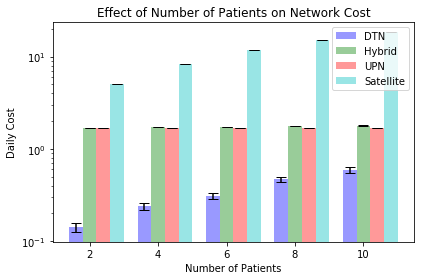

In [203]:
label = cost_return_patients.local_cost_label
label.y_label = 'Daily Cost'
plot_plots(cost_return_patients.local_cost, cost_return_patients.local_cost_err, label, additional_data=cost_return_patients.additional_data_dict)

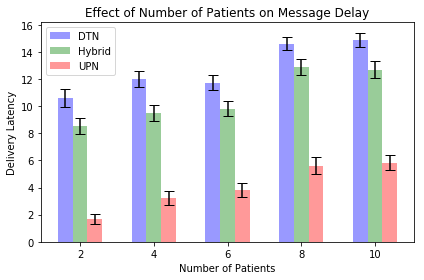

In [204]:
delay_return_patients.local_label.y_label = 'Delivery Latency'
plot_plots(delay_return_patients.local, delay_return_patients.local_err, delay_return_patients.local_label)

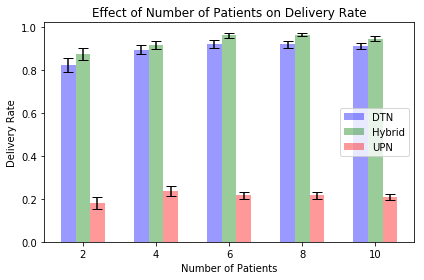

In [205]:
plot_plots(deliv_return_patients.local, deliv_return_patients.local_err, deliv_return_patients.local_label)

In [206]:
print((np.mean(deliv_return_patients.local.hybrid)-np.mean(deliv_return_patients.local.dtn))*100)
print((np.mean(deliv_return_patients.local.hybrid)-np.mean(deliv_return_patients.local.dtn))*200/(np.mean(deliv_return_patients.local.hybrid)+np.mean(deliv_return_patients.local.dtn)))
print(deliv_return_patients.local.hybrid)
print(deliv_return_patients.local.hybrid)
print('=========================')
print((np.mean(delay_return_patients.local.dtn)-np.mean(delay_return_patients.local.hybrid)))
print((np.mean(delay_return_patients.local.dtn)-np.mean(delay_return_patients.local.hybrid))*200/(np.mean(delay_return_patients.local.dtn)+np.mean(delay_return_patients.local.hybrid)))
print('=========================')
print((np.mean(cost_return_patients.local_cost.dtn)-np.mean(cost_return_patients.local_cost.hybrid))*200/(np.mean(cost_return_patients.local_cost.dtn)+np.mean(cost_return_patients.local_cost.hybrid)))
print((np.mean(cost_return_patients.local_cost.internet)-np.mean(cost_return_patients.local_cost.hybrid))*200/(np.mean(cost_return_patients.local_cost.internet)+np.mean(cost_return_patients.local_cost.hybrid)))
print((np.mean(cost_return_patients.additional_data_dict['Satellite'])-np.mean(cost_return_patients.local_cost.hybrid))*200/(np.mean(cost_return_patients.additional_data_dict['Satellite'])+np.mean(cost_return_patients.local_cost.hybrid)))





3.8216666666666677
4.179539758487127
[0.875, 0.9175, 0.9616666666666666, 0.96625, 0.9470000000000003]
[0.875, 0.9175, 0.9616666666666666, 0.96625, 0.9470000000000003]
2.0710000000000015
17.663866262953658
-132.71066527855336
-3.2781124028280515
148.21705642603905


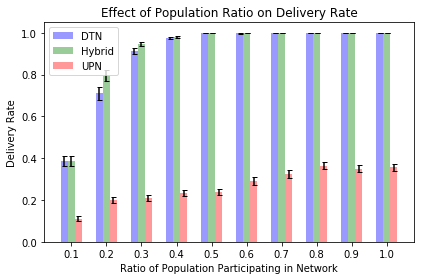

In [207]:
deliv_return_ratio.local_label.title = 'Effect of Population Ratio on Delivery Rate'
plot_plots(deliv_return_ratio.local, deliv_return_ratio.local_err, deliv_return_ratio.local_label)

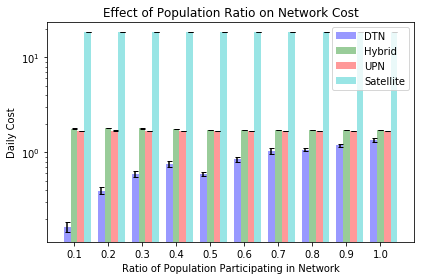

In [208]:
cost_return_ratio.local_cost_label.title = 'Effect of Population Ratio on Network Cost'
cost_return_ratio.local_cost_label.y_label = 'Daily Cost'
plot_plots(cost_return_ratio.local_cost, cost_return_ratio.local_cost_err, cost_return_ratio.local_cost_label, additional_data=cost_return_ratio.additional_data_dict)


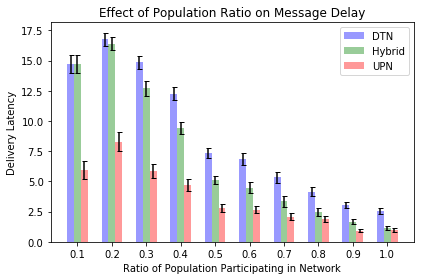

In [209]:
delay_return_ratio.local_label.title = 'Effect of Population Ratio on Message Delay'
delay_return_ratio.local_label.y_label = 'Delivery Latency'
plot_plots(delay_return_ratio.local, delay_return_ratio.local_err, delay_return_ratio.local_label)

In [210]:
print((np.mean(deliv_return_ratio.local.hybrid)-np.mean(deliv_return_ratio.local.dtn))*100)
print((np.mean(deliv_return_ratio.local.hybrid)-np.mean(deliv_return_ratio.local.dtn))*200/(np.mean(deliv_return_ratio.local.hybrid)+np.mean(deliv_return_ratio.local.dtn)))
print(deliv_return_ratio.local.hybrid)
print(delay_return_ratio.local.hybrid)
print(max(deliv_return_ratio.local.internet))

1.2400000000000078
1.3710747456877572
[0.3870000000000002, 0.7939999999999999, 0.9470000000000003, 0.9819999999999999, 0.9990000000000001, 0.9990000000000001, 0.9990000000000001, 1.0, 0.9990000000000001, 1.0]
[14.73, 16.4, 12.7, 9.425, 5.1, 4.49, 3.34, 2.455, 1.655, 1.15]
0.365
